In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import models
from torchmetrics import Accuracy

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import copy
import gc
import math
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
num_epochs = 200

batch_size = 128

classes = ('plane', 'car' , 'bird','cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
train_dataset = torchvision.datasets.CIFAR10(root= './data', train = True, download=True)
test_dataset =  torchvision.datasets.CIFAR10(root= './data', train = False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class_names = train_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

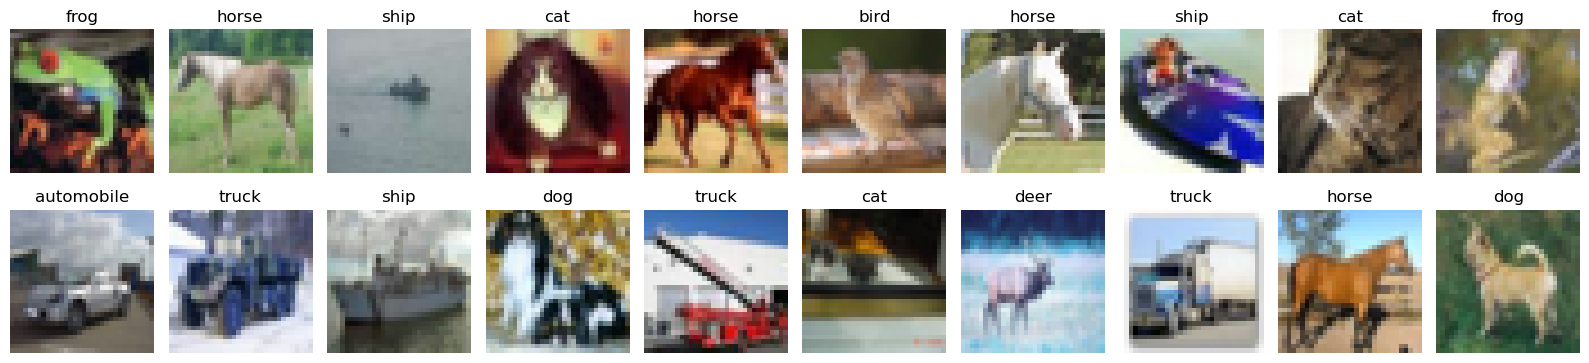

In [6]:
torch.manual_seed(42)     # Search on the internet why '42' is special or
                          # even '42 * 2' = 84

fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 10

for i in range(1, (rows*cols) + 1):
    rand_ind = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[rand_ind]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)
    plt.tight_layout()

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
cifar_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,])

In [11]:
train_dataset = torchvision.datasets.CIFAR10(root= './data', train = True, download=False, transform = cifar_transforms)
test_dataset =  torchvision.datasets.CIFAR10(root= './data', train = False, download=False, transform = cifar_transforms)

In [12]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset = train_dataset, lengths = [train_size, val_size])
len(train_dataset), len(val_dataset), len(test_dataset)

(45000, 5000, 10000)

In [15]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset =train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(dataset= test_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle=True)

In [18]:
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG,self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Linear(512,10)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg):
    layers = []
    in_channels =3
    for out_channels in cfg:
        if out_channels == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2, stride =2)]
        else:
            conv2d = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding =1)
            layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = out_channels
    return nn.Sequential(*layers)

cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

def vgg16():
    return VGG(make_layers(cfg))

In [23]:
model = vgg16()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum = 0.9, weight_decay = 5e-4)
accuracy = Accuracy(task='multiclass', num_classes=10).to(device)
eps= [0.01, 0.03, 0.06, 0.1, 0.3, 0.5]

In [62]:
from tqdm.notebook import tqdm

# device-agnostic setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
accuracy = accuracy.to(device)
model = model.to(device)

for epoch in tqdm(range(num_epochs)):
    # Training loop
    train_loss, train_acc = 0.0, 0.0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        X = projected_gradient_descent(model, X, eps[0], eps[0]/10, 40, np.inf )
        model.train()
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        acc = accuracy(y_pred, y)
        train_acc += acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
        
    # Validation loop
    val_loss, val_acc = 0.0, 0.0
    model.eval()
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            
            acc = accuracy(y_pred, y)
            val_acc += acc
            
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
    
    print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {(100* train_acc): .5f}| Val loss: {val_loss: .5f}| Val acc: {(100*val_acc): .5f}")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0| Train loss:  2.07583| Train acc:  18.65580| Val loss:  1.87540| Val acc:  23.71094
Epoch: 1| Train loss:  1.81409| Train acc:  27.94720| Val loss:  1.64626| Val acc:  32.40234
Epoch: 2| Train loss:  1.63149| Train acc:  35.83738| Val loss:  1.71327| Val acc:  32.44141
Epoch: 3| Train loss:  1.48174| Train acc:  43.19020| Val loss:  1.48831| Val acc:  42.42188
Epoch: 4| Train loss:  1.28095| Train acc:  53.67149| Val loss:  1.20335| Val acc:  57.46094
Epoch: 5| Train loss:  1.16170| Train acc:  58.56317| Val loss:  1.00691| Val acc:  66.11328
Epoch: 6| Train loss:  1.05645| Train acc:  62.90025| Val loss:  1.02730| Val acc:  65.56641
Epoch: 7| Train loss:  0.99422| Train acc:  65.09011| Val loss:  0.93358| Val acc:  68.76953
Epoch: 8| Train loss:  0.92407| Train acc:  68.20377| Val loss:  0.79054| Val acc:  73.86719
Epoch: 9| Train loss:  0.86868| Train acc:  70.04864| Val loss:  0.88268| Val acc:  73.84766
Epoch: 10| Train loss:  0.81757| Train acc:  71.85305| Val loss:  0.75

In [64]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "vgg_16_cifar_adv.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Saving the model
print(f"Saving the model: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving the model: models\vgg_16_cifar_adv.pth


C:\Users\User\AppData\Local\Temp\ipykernel_19616\3212535161.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vgg_16_cifar_adv_loaded.load_state_dict(torch.load(MOD

<All keys matched successfully>

In [77]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "vgg_16_cifar_adv.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
# Loading the saved model
model_vgg_16_cifar_adv_loaded = vgg16().to(device)
model_vgg_16_cifar_adv_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [79]:
test_loss, test_acc = 0, 0

model = model_vgg_16_cifar_adv_loaded.to(device)

model.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        
        test_loss += loss_fn(y_pred, y)
        test_acc += accuracy(y_pred, y)
        
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

print(f"Test loss: {test_loss: .5f}| Test acc: {(100*test_acc): .5f}")

Test loss:  0.65824| Test acc:  82.94106


In [201]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

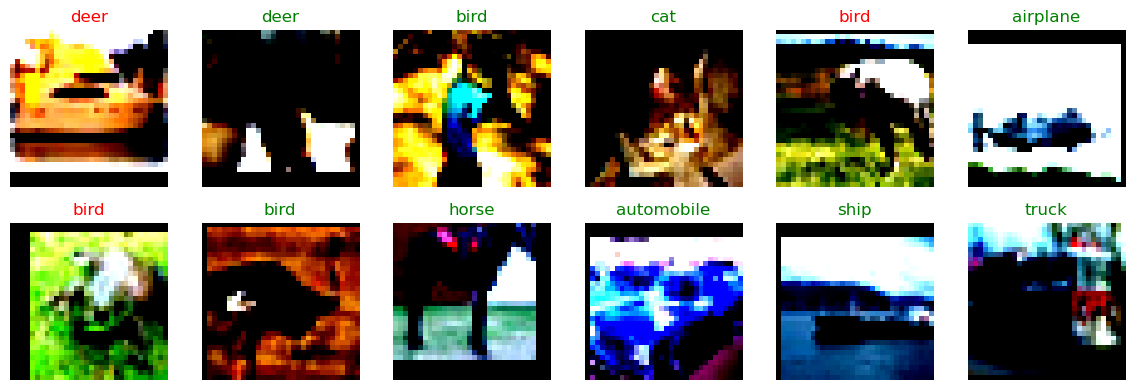

In [203]:
# See random images with their labels
torch.manual_seed(42)  # setting random seed
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12, 4))

rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
    img, label_gt = test_dataset[random_idx]
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = torch.argmax(model_vgg_16_cifar_adv_loaded(img_temp))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    plt.imshow(img, cmap='gray')
    if label_pred == label_gt:
        plt.title(class_names[label_pred], color='g') # for correct prediction
    else:
        plt.title(class_names[label_pred], color='r') # for incorrect prediction
    plt.axis(False)
    plt.tight_layout();

In [205]:
def explainer_wrapper(**kwargs):
    if kwargs["method"] == "Saliency":
        return saliency_explainer(**kwargs)
    elif kwargs["method"] == "IntegratedGradients":
        return integrated_explainer(**kwargs)
    elif kwargs["method"] == "SmoothGrad":
        return smoothgrad_explainer(**kwargs)
    elif kwargs["method"] == "NoiseGrad":
        return noisegrad_explainer(**kwargs)
    else:
        return ValueError("Explanation function doesnt exist")


def saliency_explainer(model, inputs, targets, abs=True, normalise = True, *args, **kwargs):
    gc.collect()
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1, kwargs.get("nr_channels", 3), kwargs.get("img_size", 32),kwargs.get("img_size", 32)).to(kwargs.get("device", None))
        )

    if not isinstance(targets, torch.Tensor):
        targets = (
            torch.as_tensor(targets).long().to(kwargs.get("device", None))
        )

    assert(
        len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size)"

    explanation = (
        Saliency(model)
        .attribute(inputs, targets, abs=abs)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 32), kwargs.get("img_size", 32))
        .cpu()
        .data
    )

    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


def integrated_explainer(
    model, inputs, targets, abs=True, normalise=True, *args, **kwargs
) -> np.array:

    gc.collect()
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 3),kwargs.get("img_size", 32),kwargs.get("img_size", 32),).to(kwargs.get("device", None))
        )
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (
        len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size)."
    
    explanation = (
        IntegratedGradients(model)
        .attribute(
            inputs=inputs,
            target=targets,
            baselines=torch.zeros_like(inputs),
            n_steps=10,
            method="riemann_trapezoid",
        )
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 32), kwargs.get("img_size", 32))
        .cpu()
        .data
    )

    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


def smoothgrad_explainer(model, inputs, targets, abs=True, normalise=True, stdevs=0.15, nt_samples=10, *args, **kwargs):
    std = kwargs.get("std", 0.15)  # Standard deviation for input noise
    n = kwargs.get("n", 10)  # Number of noisy samples
    clip = kwargs.get("clip", False)

    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 3),kwargs.get("img_size", 32),kwargs.get("img_size", 32),).to(kwargs.get("device", None))
        )
    
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (len(np.shape(inputs)) == 4), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size"

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (
                n,
                inputs.shape[0],
                kwargs.get("img_size", 32),
                kwargs.get("img_size", 32),
            )
        )
    else:
        explanation = torch.zeros(
            (n, kwargs.get("img_size", 32), kwargs.get("img_size", 32))
        )
    saliency = Saliency(model)
    
    # for i in range(n):
    #     # Create noisy input by adding Gaussian noise
    #     # inputs_noisy = inputs + torch.randn_like(inputs) * std
    #     # Clip the noisy inputs to the valid range if needed
    #     if clip:
    #         inputs_noisy = torch.clip(inputs_noisy, min=0.0, max=1.0)

    #     # Compute the saliency map for the noisy input
    explanation = (
        NoiseTunnel(saliency)
        .attribute(inputs=inputs, target=targets, nt_type="smoothgrad", stdevs = stdevs, nt_samples= 10)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 32), kwargs.get("img_size", 32))
        .cpu()
        .data
    )

    # explanation = explanation.mean(axis=0)
    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    # Normalization (if required)
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    # Convert the result to NumPy if it is still a PyTorch tensor
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation

def noisegrad_explainer(model, inputs, targets, abs=True, normalise=True, *args, **kwargs):
    std = kwargs.get("std", 0.5)  # Standard deviation for noise
    mean = kwargs.get("mean", 1.0)  # Mean for noise
    n = kwargs.get("n", 10)  # Number of noisy model samples
    # sg_std = kwargs.get("sg_std", 0.1)  # Standard deviation for input noise
    noise_type = kwargs.get("noise_type", "multiplicative")  # Type of noise to apply
    clip = kwargs.get("clip", False)  # Whether to clip inputs to [0, 1]

    def _apply_noise_to_model(model, std, mean, noise_type="multiplicative"):
        """Applies noise to the model parameters."""
        # Create the Gaussian distribution for noise.
        distribution = torch.distributions.normal.Normal(mean, std)
        if std == 0.0:
            with torch.no_grad():
                for param in model.parameters():
                    if noise_type == "additive":
                        param.add_(distribution.sample(param.size()).to(param.device))
                    elif noise_type == "multiplicative":
                        param.mul_(distribution.sample(param.size()).to(param.device))
                    else:
                        raise ValueError("Invalid noise_type. Choose 'additive' or 'multiplicative'.")
        return model

    # Set model to evaluation mode and move it to the appropriate device.
    model.to(kwargs.get("device", None))
    model.eval()

    # Prepare the input data.
    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 3),kwargs.get("img_size", 32),kwargs.get("img_size", 32),).to(kwargs.get("device", None))
        )

    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert len(inputs.shape) == 4, "Inputs should be of shape (nr_samples, nr_channels, img_size, img_size)."

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (
                n,
                inputs.shape[0],
                kwargs.get("img_size", 32),
                kwargs.get("img_size", 32),
            )
        )
    else:
        explanation = torch.zeros(
            (n, kwargs.get("img_size", 32), kwargs.get("img_size", 32))
        )


    for i in range(n):
        # Apply noise to the model.
        noisy_model = _apply_noise_to_model(model, std=std, mean=mean, noise_type=noise_type)

        # Add noise to the input.
        # inputs_noisy = inputs + torch.randn_like(inputs) * sg_std

        # Optionally clip the inputs to the valid range.
        # if clip:
        #     inputs_noisy = torch.clip(inputs_noisy, min=0.0, max=1.0)

        # Compute the saliency map for the noisy model and inputs.
        explanation[i] = (
            Saliency(noisy_model)
            .attribute(inputs, targets, abs=abs)
            .sum(axis=1)
            .reshape(-1, kwargs.get("img_size", 32), kwargs.get("img_size", 32))
            .cpu()
            .data
        )

    # Average the explanations across the noisy samples.
    explanation = explanation.mean(axis=0)

    # Memory management to free unused memory.
    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    # Normalize the explanation if needed.
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    # Convert to NumPy array if it is still a PyTorch tensor.
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation



In [207]:
# gc.collect()
# torch.cuda.empty_cache()

# x_batch, y_batch = next(iter(test_dataloader))
# x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [209]:
import gc
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = saliency_explainer(model=model_vgg_16_cifar_adv_loaded.cpu(),
                                    inputs=x_batch,
                                    targets=y_batch,
                                    **{"device": device},
                                    )
# Integrated Gradients.
gc.collect()
torch.cuda.empty_cache()
a_batch_integrad = integrated_explainer(model=model_vgg_16_cifar_adv_loaded.cpu(),
                                    inputs=x_batch,
                                    targets=y_batch,
                                    **{"device": device},
                                    )

# SmoothGrad
gc.collect()
torch.cuda.empty_cache()
a_batch_smoothgrad = smoothgrad_explainer(model=model_vgg_16_cifar_adv_loaded.to(device), 
                                        inputs=x_batch, 
                                        targets=y_batch,
                                        **{ "device": device})

gc.collect()
torch.cuda.empty_cache()

# # Posterior mean setup for NoiseGrad (same as FusionGrad)
# # posterior_mean = copy.deepcopy(torchvision.model_lenet5_v1_mnist_loaded.to(device).state_dict())

# NoiseGrad explanation for a batch of inputs
a_batch_noisegrad = noisegrad_explainer(
    model=model_vgg_16_cifar_adv_loaded.to(device),
    inputs=x_batch,
    targets=y_batch,
    **{
        # "posterior_mean": posterior_mean,  # The base model's mean parameters
        "mean": 1.0,  # Mean for the Gaussian noise applied to model parameters
        "std": 0.5,  # Standard deviation for the Gaussian noise applied to model parameters
        # "sg_std": 0.5,  # Standard deviation for the noise added to the inputs
        "n": 20,  # Number of noisy models to sample
        "noise_type": "multiplicative",  # Type of noise to apply to the model parameters
        "clip": False,  # Optionally clip noisy inputs between [0, 1]
        "device": device  # Device for computation (GPU/CPU)
    }
)


In [210]:
explanations = {
    "Saliency": a_batch_saliency,
    "IntegratedGradients": a_batch_integrad,
    "SmoothGrad": a_batch_smoothgrad,
    "NoiseGrad": a_batch_noisegrad,
}

In [211]:
xai_methods = list(explanations.keys())
metrics = {
    "Faithfulness":  quantus.ROAD(
        noise=0.01,
        perturb_func=quantus.perturb_func.noisy_linear_imputation,
        percentages=list(range(1, 100, 5)),
        display_progressbar=False,
    ),
    "Input Stability": quantus.RelativeInputStability(
        nr_samples =5,
        return_aggregate=False,
         disable_warnings=True,
    ),
     "Output Stability": quantus.RelativeOutputStability(
        nr_samples = 5,
         return_aggregate=False,
        disable_warnings=True,
    ),
    "Sparseness":  quantus.Sparseness(disable_warnings=True, return_aggregate=True),
    
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


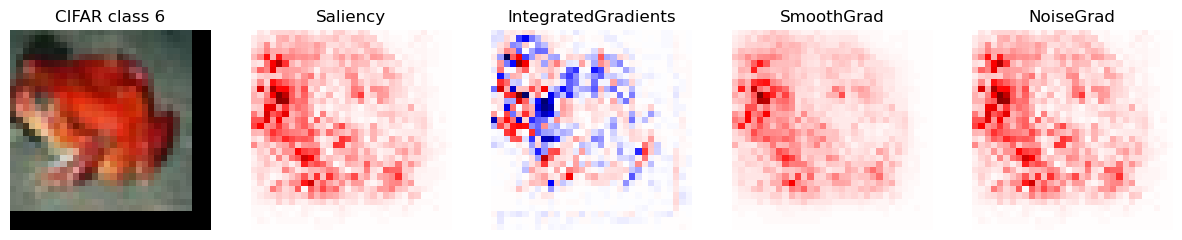

In [212]:
index = 5
#random.randint(0, len(x_batch)-1)
fig, axes = plt.subplots(nrows=1, ncols=1+len(explanations), figsize=(15, 8))
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(x_batch[index].cpu().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"CIFAR class {y_batch[index].item()}")
axes[0].axis("off"); 
for i, (k, v) in enumerate(explanations.items()):
    axes[i+1].imshow(quantus.normalise_func.normalise_by_negative(explanations[k][index].reshape(32, 32)), cmap="seismic", vmin=-1.0, vmax=1.0)
    axes[i+1].title.set_text(f"{k}")
    axes[i+1].axis("off");

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


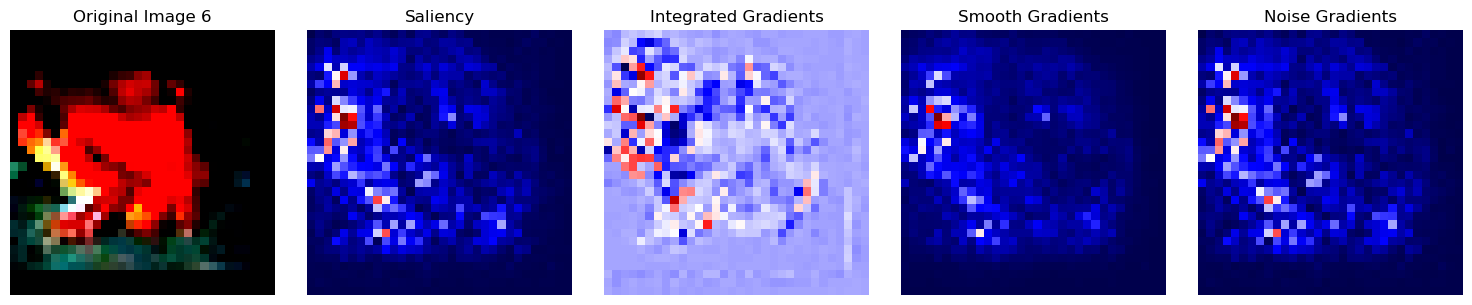

In [217]:
# Plot explanations of normal images!
index = 5
nr_images = 3
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(nr_images*5, int(nr_images)))

#plot normal
axes[0].imshow(np.moveaxis(x_batch[index].cpu().numpy(), 0, -1), vmin=0.0, vmax=1.0, cmap="gray")
axes[0].title.set_text(f"Original Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency[index], cmap="seismic")
axes[1].title.set_text(f"Saliency")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad[index], cmap="seismic")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad[index], cmap="seismic")
axes[3].title.set_text(f"Smooth Gradients")
axes[3].axis("off")
axes[4].imshow(a_batch_noisegrad[index], cmap="seismic")
axes[4].title.set_text(f"Noise Gradients")
axes[4].axis("off")
plt.tight_layout()


plt.show()

In [119]:
# Or, run quantification analysis!
import copy
results = {method : {} for method in xai_methods}

for method in xai_methods:
    for metric, metric_func in metrics.items():

        print(f"Evaluating {metric} of {method} method.")
        gc.collect()
        torch.cuda.empty_cache()
        model=model_vgg_16_cifar_adv_loaded.to(device)
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        # Get scores and append results.
        scores = metric_func(
            model = model,
            x_batch=x_batch.cpu().numpy(),
            y_batch=y_batch.cpu().numpy(),
            a_batch=None,
            s_batch=None,
            device=device,
            explain_func=explainer_wrapper,
            explain_func_kwargs={
                "method": method,
                "posterior_mean": copy.deepcopy(
                    model_vgg_16_cifar_adv_loaded
                    .to(device)
                    .state_dict()
                ),
                "mean": 1.0,
                "std": 0.5,
                "sg_mean": 0.0,
                "sg_std": 0.5,
                "n": 25,
                "m": 25,
                "noise_type": "multiplicative",
                "device": device,
            },
        )
        results[method][metric] = scores

        # Empty cache.
        gc.collect()
        torch.cuda.empty_cache()
print(results)

Evaluating Faithfulness of Saliency method.
Evaluating Input Stability of Saliency method.
Evaluating Output Stability of Saliency method.
Evaluating Sparseness of Saliency method.
Evaluating Faithfulness of IntegratedGradients method.
Evaluating Input Stability of IntegratedGradients method.
Evaluating Output Stability of IntegratedGradients method.
Evaluating Sparseness of IntegratedGradients method.
Evaluating Faithfulness of SmoothGrad method.
Evaluating Input Stability of SmoothGrad method.
Evaluating Output Stability of SmoothGrad method.
Evaluating Sparseness of SmoothGrad method.
Evaluating Faithfulness of NoiseGrad method.
Evaluating Input Stability of NoiseGrad method.
Evaluating Output Stability of NoiseGrad method.
Evaluating Sparseness of NoiseGrad method.
{'Saliency': {'Faithfulness': {1: 0.9655172413793104, 6: 0.9137931034482759, 11: 0.853448275862069, 16: 0.7931034482758621, 21: 0.6896551724137931, 26: 0.6379310344827587, 31: 0.5603448275862069, 36: 0.5086206896551724, 

In [123]:

results_agg = {}
for method in xai_methods:
    results_agg[method] = {}
    for metric, metric_func in metrics.items():
        # print(method)
        # print(metric)
        value = (results[method][metric])
        # print("Value", value)
        if metric == "Faithfulness":
            results_agg[method][metric] = np.mean(list(value.values()))
        else:
            results_agg[method][metric] = np.mean(list(value))

epsilon = 1e-8
df = pd.DataFrame.from_dict(results_agg)
df = df.T.abs()

df["Input Stability"] = df["Input Stability"].replace(0, np.nan).fillna(epsilon)
df["Output Stability"] = df["Output Stability"].replace(0, np.nan).fillna(epsilon)
print(df)

# Take inverse ranking for Robustness, since lower is better.
df_normalised = df.loc[:, (df.columns != 'Input Stability') & (df.columns != 'Output Stability')].apply(lambda x: x / x.max())

df_normalised["Input Stability"] = df["Input Stability"].min()/df["Input Stability"].values 
df_normalised["Output Stability"] = df["Output Stability"].min()/df["Output Stability"].values
df_normalised_rank = df_normalised.rank()
df_normalised_rank

                     Faithfulness  Input Stability  Output Stability  \
Saliency                 0.451724     1.000000e-08      1.000000e-08   
IntegratedGradients      0.378879     1.000000e-08      1.000000e-08   
SmoothGrad               0.427155     1.000000e-08      1.000000e-08   
NoiseGrad                0.450862     1.000000e-08      1.000000e-08   

                     Sparseness  
Saliency               0.592123  
IntegratedGradients    0.672911  
SmoothGrad             0.523319  
NoiseGrad              0.592123  


,Faithfulness,Sparseness,Input Stability,Output Stability
Saliency,4.0,3.0,2.5,2.5
IntegratedGradients,1.0,4.0,2.5,2.5
SmoothGrad,2.0,1.0,2.5,2.5
NoiseGrad,3.0,2.0,2.5,2.5
